In [3]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '/home/maiwenn/these/topo_database/GRATIOSA')
import Genome
from scipy import interpolate
from scipy.integrate import trapz
import matplotlib.pyplot as plt
import Chipseq, Transcriptome, GO
import stat_analysis
import plot_stat_analysis
cm = 1/2.54  # centimeters in inches
outdir = "/home/maiwenn/these/resdir/"

# 1 - Data importation and pre-processing

Genome object initialization and sequence loading

In [4]:
g = Genome.Genome("ecoli_W3110_Mu")
g.load_seq()

### A - Transcription Units positions and expressions

Loading of transcription units (TU) data present in the TU folder. Here, we will use the annotation and expression data published by Sutormin et al. These data are loaded as "start", "end", "strand", and "expression" attributes of each TU object.

In [5]:
g.load_TU()

Selection of TUs containing at least one stable RNAs

In [6]:
 #TUrtRNA: list of TUs with at least one stable RNA 
allTUs = list(g.TUs["TUSutormin"].keys())
TUrtRNA = [126,  127,  133,  147,  243,  288,  329,  404,  405,  460,  461,
           488,  578,  773,  903,  935,  936,  939,  942, 1004, 1050, 1066,
           1071, 1164, 1165, 1205, 1266, 1267, 1285, 1347, 1391, 1431, 1432,
           1433, 1434, 1435, 1436, 1437, 1439, 1440, 1441, 1497, 1498, 1642,
           1699, 1700, 1757, 1758, 1783, 1784, 1808, 1809, 1863, 1864, 1865,
           1866, 1868, 1881, 1882, 1950, 1971, 2028, 2059, 2112, 2126, 2128,
           2137, 2139, 2140, 2142, 2145, 2152, 2157]
TUother = list(set(allTUs) - set(TUrtRNA))

# Separation of expression data based on the presence of stable RNA
TU_expr = {"rtRNA":{},"other":{}}
for ID, TU in g.TUs["TUSutormin"].items():
    if ID in TUrtRNA:
        TU_expr["rtRNA"][ID] = TU.expression
    else : 
        TU_expr["other"][ID] = TU.expression

### B - Chipseq signals
Chipseq object initialization

In [7]:
ch = Chipseq.Chipseq("ecoli_W3110_Mu")

Average of replicates and smoothing on 500b windows for TopoI and Gyrase signals

In [8]:
condTopo = ["Sutormin_shift_TopoI_R1","Sutormin_shift_TopoI_R2","Sutormin_shift_TopoI_R3"]
Topo_average_name = "TopoSutormin_WT_shift_500b"

ch.load_signals_average(list_cond=condTopo,
                        average_name=Topo_average_name,
                       data_treatment = "smoothing",
                       window=500)
Topo_signal = ch.signals_average[Topo_average_name]

loading the file obtained with the following parameters:

Name: TopoSutormin_WT_shift_500b

 Replicates: ['Sutormin_shift_TopoI_R1', 'Sutormin_shift_TopoI_R2', 'Sutormin_shift_TopoI_R3']

 Data treatment: smoothing

 Size (window or bin, in b): 500

Please change 'average_name' to use other signals


In [9]:
condGyr = ['Sutormin_shift_Gyrase_R1', 'Sutormin_shift_Gyrase_R2']
Gyr_average_name = "GyrSutormin_WT_shift_500b"

ch.load_signals_average(list_cond=condGyr,
                        average_name=Gyr_average_name,
                       data_treatment = "smoothing",
                       window=500)
Gyr_signal = ch.signals_average[Gyr_average_name]

loading the file obtained with the following parameters:

Name: GyrSutormin_WT_shift_500b

 Replicates: ['Sutormin_shift_Gyrase_R1', 'Sutormin_shift_Gyrase_R2']

 Data treatment: smoothing

 Size (window or bin, in b): 500

Please change 'average_name' to use other signals


In [24]:
all_signals = {"Gyr" : Gyr_signal, "Topo" : Topo_signal}

# 2 - TU classification in expression classes

Classification with chosen class sizes

ME: 1300 elements
4: 200 elements
3: 200 elements
2: 200 elements
1: 200 elements


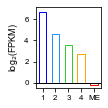

In [17]:
classif_TUs = stat_analysis.data_classification(
    data_x=TU_expr["other"].keys(),
    data_y=TU_expr["other"].values(),
    class_nb=5,
    class_names=["ME", 4, 3, 2, 1],
    class_sizes=[len(TUother)-800, 200, 200, 200, 200]
)

classif_TUs[0]["rtRNA"]=list(TU_expr["rtRNA"].keys())
classif_TUs[1]["rtRNA"]=list(TU_expr["rtRNA"].values())

class_means = {}
for exprclass in [1,2,3,4,"ME"]:
    class_means[exprclass] = np.mean([np.log2(x) for x in classif_TUs[1][exprclass] if x != 0])

Classification in expression deciles

In [19]:
classif_deciles = stat_analysis.data_classification(
    data_x=TU_expr["other"].keys(),
    data_y=TU_expr["other"].values(),
    class_nb=10
)

classif_deciles[0]["rtRNA"]=list(TU_expr["rtRNA"].keys())
classif_deciles[1]["rtRNA"]=list(TU_expr["rtRNA"].values())

Performing the classification in the following classes:
0: from 0.0 to 0.2219460405665605
1: from 0.2228635134981604 to 0.5004320721857773
2: from 0.5006399528507197 to 0.983472590568697
3: from 0.9931627185897828 to 1.799746695169979
4: from 1.8003913626035322 to 3.0709541322556704
5: from 3.0768155202341028 to 4.984718475437905
6: from 4.993359039494553 to 8.103959961281214
7: from 8.105314740027312 to 15.844014036290488
8: from 15.868638890337257 to 37.766937523681115
9: from 37.952086050606454 to 1522.949849756477
0: 210 elements
1: 210 elements
2: 210 elements
3: 210 elements
4: 210 elements
5: 210 elements
6: 210 elements
7: 210 elements
8: 210 elements
9: 210 elements


# 3 - Stat analysis and graphical representations

### A - Average expression of each expression class

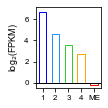

In [18]:
cat_colors = ["blue", "dodgerblue", "limegreen", "orange", "red"]
fig, ax = plt.subplots(figsize=(4*cm, 4*cm))
ax.bar([str(c) for c in class_means.keys()], class_means.values(),
       color='white', edgecolor=cat_colors, width=0.6, linewidth=1)
ax.set_ylim(-0.5, 7.2)
ax.set_ylabel("log$_2$(FPKM)")
ax.axhline(0, color="black", lw=1)
ax.set_yticks(np.arange(0, 8, 2))
plt.tight_layout()

### B - Average signals of each expression class in a window of +- 10kb around the TU

In [12]:
# Define the window size before and after the TU
ws = 10000

# Initialize dictionaries to store results by signal type ("Gyr" and "Topo")
# and classification group ("ME", 4, 3, 2, 1)
means = {"Gyr":{}, "Topo":{}}
TUsignals = {"Gyr":{}, "Topo":{}}
interpolsignal = {"Gyr":{}, "Topo":{}}
df_sign = {"Gyr":{}, "Topo":{}}
for styp in ["Gyr","Topo"] : 
    for exprclass in ["rtRNA",1,2,3,4,"ME"] : 
        means[styp][exprclass] = {}
        TUsignals[styp][exprclass] = {}
        interpolsignal[styp][exprclass] = {}
        df_sign[styp][exprclass] = {}  
        
# Loop over each TU of each expression class
for exprclass in ["rtRNA",1,2,3,4,"ME"] : 
    for ID in classif_TUs[0][exprclass] : 
        TU = g.TUs["TUSutormin"][ID]

        # Define the start and end of the window around the TU
        w_start = TU.start - ws
        w_end = TU.end + ws

        # Initialize a dictionary to store signals for each signal type ("Gyr" and "Topo")
        g_signals = {}
        
        # If the window extends beyond the start or end of the genome, wrap around to the other side
        if w_start < 0:
            for styp in ['Gyr', 'Topo']:
                 TUsignals[styp][exprclass][ID] = np.concatenate((all_signals[styp][g.length + w_start - 1:],
                                                                  all_signals[styp][:w_end]))
        elif w_end > g.length:
            for styp in ['Gyr', 'Topo']:
                 TUsignals[styp][exprclass][ID] = np.concatenate((all_signals[styp][w_start:],
                                                                  all_signals[styp][:w_end - g.length + 1]))
        else:
            for styp in ['Gyr', 'Topo']:
                 TUsignals[styp][exprclass][ID] = all_signals[styp][w_start:w_end]

        # If the TU is on the negative strand, flip the signals
        if not TU.strand: 
            for styp in ['Gyr', 'Topo']:
                 TUsignals[styp][exprclass][ID] = np.flip(TUsignals[styp][exprclass][ID])

        # Interpolate the signal within the window to 2000 points 
        for styp in ['Gyr', 'Topo']:
            inTU_sign =  TUsignals[styp][exprclass][ID][ws:-ws]
            f = interpolate.interp1d(np.arange(len(inTU_sign)), inTU_sign)           
            x = np.linspace(0,len(inTU_sign)-1,num=2000)
            inTU_sign = f(x)          
            interpolsignal[styp][exprclass][ID] = np.concatenate((TUsignals[styp][exprclass][ID][:ws], inTU_sign,  TUsignals[styp][exprclass][ID][-ws:]))
                 
# Convert the signals into DataFrame and calculate the mean signal for each expression class
    for styp in ['Gyr', 'Topo']:
        df_sign[styp][exprclass] = pd.DataFrame(interpolsignal[styp][exprclass])
        means[styp][exprclass] = df_sign[styp][exprclass].mean(axis=1)

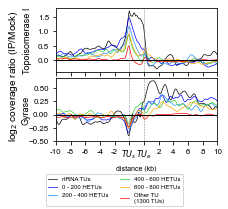

In [13]:
# Create a figure with 2 subplots (1 per signal type)
fig, ax = plt.subplots(2,1, figsize=(7.8*cm,7*cm))
fig.subplots_adjust(hspace=0.1, left=0.22, right=0.95, bottom=0.32, top=0.99)

# Create an array with indices for the x-axis
x = np.arange(len(means[styp]["ME"]))

# Define a list of colors and labels for the expression categories
colors = ["black","blue", "dodgerblue", "limegreen", "orange","red"]
lme = len(classif_TUs[0]["ME"]) # get the number of TUs classified as "ME"
labels = ["rtRNA TUs","0 - 200 HETUs","200 - 400 HETUs","400 - 600 HETUs","600 - 800 HETUs",f"Other TU\n({lme} TUs)"]

for p, styp in enumerate(["Topo", "Gyr"]):
    # Loop over the expression categories and plot their mean TU signals
    for ec, exprclass in enumerate(["rtRNA",1,2,3,4,"ME"]):
        ax[p].plot(x, means[styp][exprclass], label=labels[ec], c=colors[ec], lw=0.7)
                
    # Add a horizontal line at y=0, a vertical line at the start of the TU,
    # and another one at the end of the TU
    ax[p].axhline(0, color='black', lw=1)
    ax[p].set_xlim(0, ws*2+2000)
    ax[p].axvline(ws, color='grey', ls='--', lw=0.5)
    ax[p].axvline(ws+2000, color='grey', ls='--', lw=0.5)

# Set the axis and ticks labels
ax[0].set_ylabel("Topoisomerase I", labelpad=6, fontsize=9)
ax[1].set_ylabel("Gyrase", labelpad=-2, fontsize=9)
ax[1].set_xlabel("distance (kb)", fontsize=7)
for i in [0, 1]:
    ax[i].set_xticks(np.arange(0, 2*ws+2001, ws/5))
ax[0].set_yticks(np.arange(0, 2, 0.5))
ax[1].set_yticks(np.arange(-0.5, 0.75, 0.25))
ax[0].set_xticklabels([])
ax[1].set_xticklabels(np.concatenate((np.arange(-ws/1000,-ws/6000,ws/6000, dtype=int),
                                      ['$TU_s$','$TU_e$'],                    
                                      np.arange(ws/6000+1,ws/1000+1,ws/6000, dtype=int))))
fig.text(0.00, 0.65, 'log$_2$ coverage ratio (IP/Mock)', va='center', rotation='vertical',fontsize = 10)
            
# Set the legend
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels,fontsize=6,handlelength=1.5,loc='lower center',ncol=2)

plt.savefig(f"{outdir}fig3-signaux.svg",transparent=False,facecolor='white')

## C - Average signals per expression deciles in, before and after the TU

TopoI and Gyrase signals per expression deciles

In [65]:
# Define the window size before and after the TU
ws = 10000

all_signals = {"Gyr" : Gyr_signal,"Topo":Topo_signal}
signal_per_exprclass = {}

for s in ["Gyr","Topo"] : 
    
    # Initialize dictionary to store results by signal type ("Gyr" and "Topo")
    # and region relative to the TU ("before","in","after")
    signal_per_exprclass[s] = {}
    for pos in ["before","in","after"]:
        signal_per_exprclass[s][pos] = {}
        for i in classif_deciles[0].keys() : 
            signal_per_exprclass[s][pos][i] = []
            
    # Loop over each TU of each expression decile to compute the average signal for each 
    # signal type and each region
    for i in classif_deciles[0].keys() : 
        for ID in classif_deciles[0][i] :
            TU = g.TUs["TUSutormin"][ID]

            signal_per_exprclass[s]["in"][i].append(np.mean(all_signals[s][TU.start:TU.end]))
            if TU.strand :
                signal_per_exprclass[s]["after"][i].append(np.mean(all_signals[s][TU.end:TU.end+ws]))
                if ws <= TU.start : 
                    signal_per_exprclass[s]["before"][i].append(np.mean(all_signals[s][TU.start-ws:TU.start]))
                # If the window extends beyond the start of the genome, wrap around to the other side
                elif ws > TU.start : 
                    diff = ws - TU.start
                    sign = np.concatenate([all_signals[s][:TU.start],all_signals[s][-diff:]])
                    signal_per_exprclass[s]["before"][i].append(np.mean(sign))

            else :
                signal_per_exprclass[s]["before"][i].append(np.mean(all_signals[s][TU.end:TU.end+ws]))
                if ws <= TU.start : 
                    signal_per_exprclass[s]["after"][i].append(np.mean(all_signals[s][TU.start-ws:TU.start]))
                # If the window extends beyond the start of the genome, wrap around to the other side
                elif ws > TU.start : 
                    diff = ws - TU.start
                    sign = np.concatenate([all_signals[s][:TU.start],all_signals[s][-diff:]])
                    signal_per_exprclass[s]["after"][i].append(np.mean(sign))

Expression values per expression deciles

In [66]:
signal_per_exprclass["expr"] = {}
signal_per_exprclass["expr"]["in"] = classif_deciles[1]

Student test to get all means and confidence intervals

In [67]:
res = {}
for s in ["Gyr","Topo","expr"] : 
    res[s] = {}
    for pos in signal_per_exprclass[s].keys():
        res[s][pos]=stat_analysis.quantitative_data_student_test(
            signal_per_exprclass[s][pos],
            output_dir=outdir,
            output_file=f"{s}_{pos}_TU_exprdeciles")           

Results saved in /home/maiwenn/these/resdir/Gyr_before_TU_exprdeciles
Results saved in /home/maiwenn/these/resdir/Gyr_in_TU_exprdeciles
Results saved in /home/maiwenn/these/resdir/Gyr_after_TU_exprdeciles
Results saved in /home/maiwenn/these/resdir/Topo_before_TU_exprdeciles
Results saved in /home/maiwenn/these/resdir/Topo_in_TU_exprdeciles
Results saved in /home/maiwenn/these/resdir/Topo_after_TU_exprdeciles
Results saved in /home/maiwenn/these/resdir/expr_in_TU_exprdeciles


Graphical representation

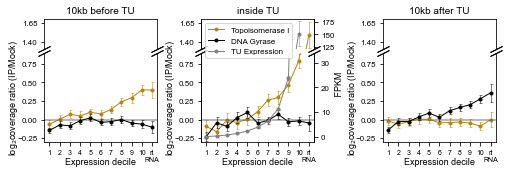

In [68]:
plt.rcParams.update({'font.size': 8,
                     'font.family': "Arial",
                     'xtick.labelsize': 7,
                     'ytick.labelsize': 8,
                     'axes.labelsize': 9,
                     'axes.titlesize': 10})

width = 0.25

# Extraire les noms de catégorie et les moyennes de chaque dictionnaire
expr_cats = res['Gyr']['before']['categories']
categories = ['before','in','after']
labels_cats = list(np.arange(1,11))+['rt\nRNA']
legend_cats = ['10kb before TU','inside TU','10kb after TU']
p = np.arange(len(expr_cats))
legend = ["Topoisomerase I","DNA Gyrase","expression"]


fig, ax = plt.subplots(2,3, figsize=(17.5/2.54,2.5), sharex=True,gridspec_kw={'height_ratios': [1, 3]})
fig.subplots_adjust(hspace=0.06,wspace=0.5,left=0.07, right=0.98,bottom=0.20)

colors = ['darkgoldenrod',"black"]
for a in [0,1] :
    for i,c in enumerate(categories) : 

        for j,s in enumerate(["Topo",'Gyr']) : 


            means = res[s][c]['means']

            ci = np.zeros((2,len(expr_cats)))
            for ca in np.arange(len(expr_cats)):
                ci[0,ca] = means[ca] - res[s][c]["confidence intervals"][ca][0]
                ci[1,ca] = res[s][c]["confidence intervals"][ca][1]-means[ca]

            ax[a,i].plot(p, means, '-o',label=legend[j],lw=1,markersize=3,color=colors[j])
            ax[a,i].errorbar(p, means, yerr= ci,capsize = 1.5,elinewidth = 0.5,capthick = 0.5,
                     fmt="none",color=colors[j])
            
            
        ax[0,i].set_title(legend_cats[i])

        # Ajouter des étiquettes d'axe, de titre et de légende
        ax[0,i].set_xticks(p)
        
        ax[0,i].set_ylim(1.3,1.7)
        ax[1,i].set_ylim(-0.3,0.9)
        
        # hide the spines between ax and ax2
        ax[0,i].spines.bottom.set_visible(False)
        ax[1,i].spines.top.set_visible(False)        
       
        ax[a,i].tick_params(labeltop=False)  # don't put tick labels at the top
        ax[a,i].xaxis.tick_bottom()
        ax[0,i].tick_params(axis='x', colors='white')
        ax[1,i].set_xlabel('Expression decile',labelpad=-5)
        
        d = .5  # proportion of vertical to horizontal extent of the slanted line
        kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
        ax[0,i].plot([0, 1], [0, 0], transform=ax[0,i].transAxes, **kwargs)
        ax[1,i].plot([0, 1], [1, 1], transform=ax[1,i].transAxes, **kwargs)

        ax[0,i].set_xticklabels(labels_cats)
        ax[1,i].set_yticks(np.arange(-0.25,1,0.25))
        ax[0,i].set_yticks(np.arange(1.4,1.7,0.25))
        
        
        ax[1,i].set_ylabel("log$_2$coverage ratio (IP/Mock)", labelpad=-3)

            
        ax[1,i].axhline(y=0,lw=0.3,c="black")
        
        
means = res['expr']['in']['means']

ci = np.zeros((2,len(expr_cats)))
for ca in np.arange(len(expr_cats)-1):
    ci[0,ca] = means[ca] - res['expr']['in']["confidence intervals"][ca][0]
    ci[1,ca] = res['expr']['in']["confidence intervals"][ca][1]-means[ca]

axbis = ax[1,1].twinx()
axbis.spines.bottom.set_visible(False)
axbis.spines.top.set_visible(False)        
axbis.plot(p[:-1], means[:-1], '-o',label='TU Expression',lw=1,color="gray",markersize=3)
axbis.set_ylim(-2,34)
axbis.errorbar(p, means, yerr= ci,
                     ecolor = "gray",capsize = 1.5,elinewidth = 0.5,capthick = 0.5,
                     fmt="none")
axbis.set_ylabel(f'           FPKM',labelpad=5)

axhaut = ax[0,1].twinx()
axhaut.spines.bottom.set_visible(False)
axhaut.spines.top.set_visible(False)        
axhaut.plot(p[:-1], means[:-1], '-o',label='TU Expression',lw=1,color="gray",markersize=3)
axhaut.set_ylim(120,180)
axhaut.errorbar(p, means, yerr= ci,
                     ecolor = "gray",capsize = 1.5,elinewidth = 0.5,capthick = 0.5,
                     fmt="none")

lines, labels = ax[0,0].get_legend_handles_labels()
lines2, labels2 = axhaut.get_legend_handles_labels()
axhaut.legend(lines + lines2, labels + labels2, loc='upper left')

for a in [0,1]: 
    pos1 = ax[a,1].get_position()
    pos1_new = [pos1.x0-0.025, pos1.y0, pos1.width , pos1.height] 
    ax[a,1].set_position(pos1_new)
    
plt.savefig(f"{outdir}/signals_TUdeciles.svg", transparent=True,facecolor='white')